In [1]:
from detect import run

In [2]:
#img = 'data/dwg/images/val'
img = 'data/dwg/images/val/c8fae7c9-3788-4d6c-a767-7e26ed098419.bmp'
#img = 'data/dwg/images/val/11c4395a-51a1-4c1b-8be7-dd61d30a5681.bmp'
run(weights='runs/train/exp/weights/best-s.pt', source=img, nosave=False, save_txt=False, imgsz=512, conf_thres=0.2, iou_thres=0.2, exist_ok=True, line_thickness=1)


YOLOv5 🚀 v5.0-338-g8c0628f torch 1.9.0+cu102 CPU

Fusing layers... 
/home/mk/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPs


image 1/1 /home/mk/yolov5/data/dwg/images/val/c8fae7c9-3788-4d6c-a767-7e26ed098419.bmp: 512x512 14 DimExtPnts, 9 DimBounds, Done. (0.226s)
Results saved to runs/detect/exp
Done. (0.239s)


In [3]:
 !python detect.py --weights runs/train/exp/weights/best-s.pt --source data/dwg/images/train/0b8c9c96-5361-47ca-8a60-db6ecbb2170c.bmp --imgsz 512 --conf-thres 0.5 --iou-thres 0.2 --exist-ok --save-txt

detect: weights=['runs/train/exp/weights/best-s.pt'], source=data/dwg/images/train/0b8c9c96-5361-47ca-8a60-db6ecbb2170c.bmp, imgsz=512, conf_thres=0.5, iou_thres=0.2, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-338-g8c0628f torch 1.9.0+cu102 CPU

Fusing layers... 
/home/mk/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 

YOLOv5 🚀 v5.0-338-g8c0628f torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPs
val: Scanning 'data/dwg/val.cache' images and labels... 50 found, 0 missing, 5 empty, 0 corrupted: 100%|██████████| 50/50 [00:00<00:00, 75464.27it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0%|          | 0/4 [00:00<?, ?it/s]

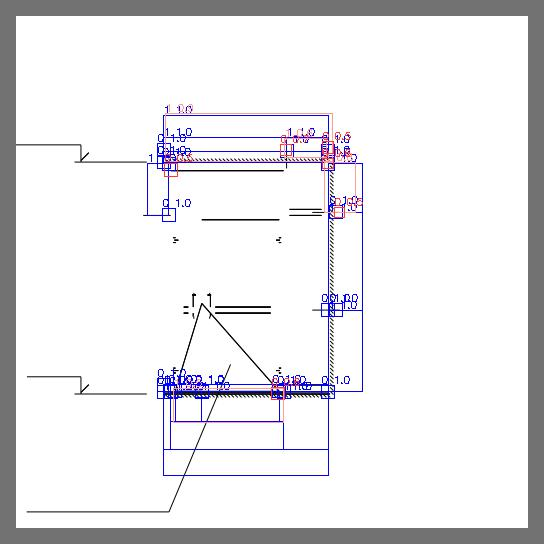

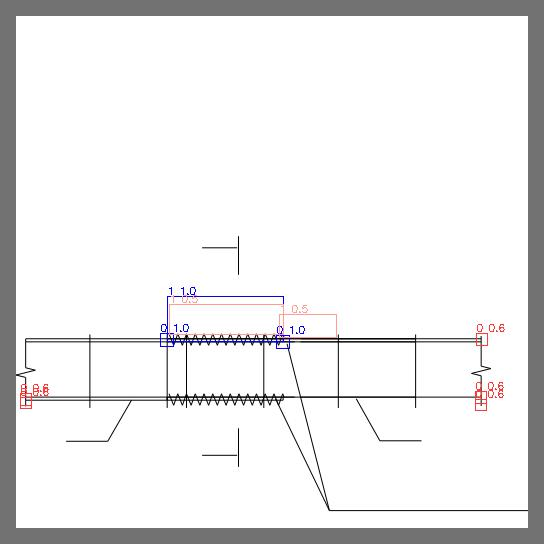

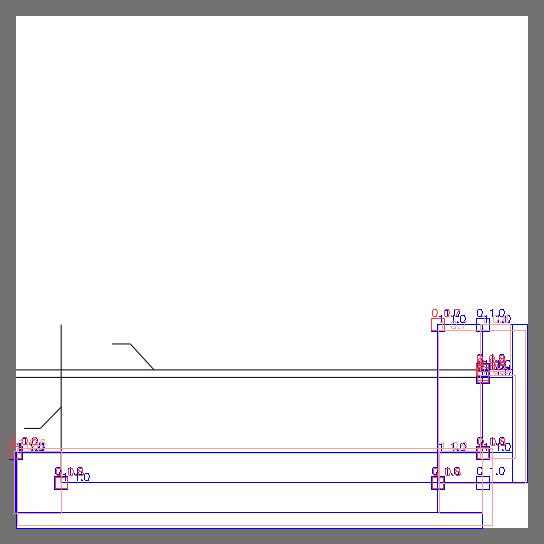

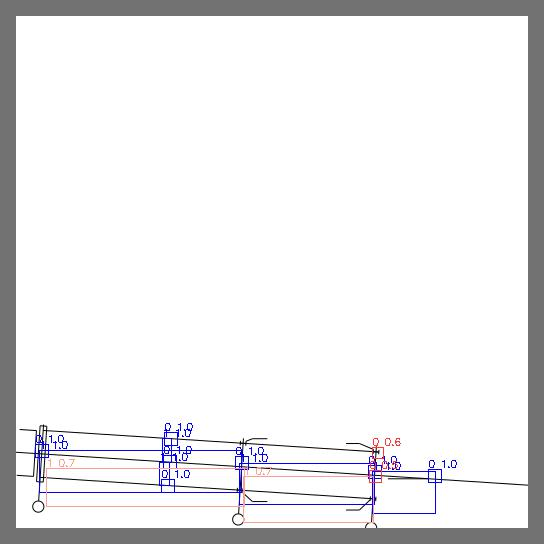

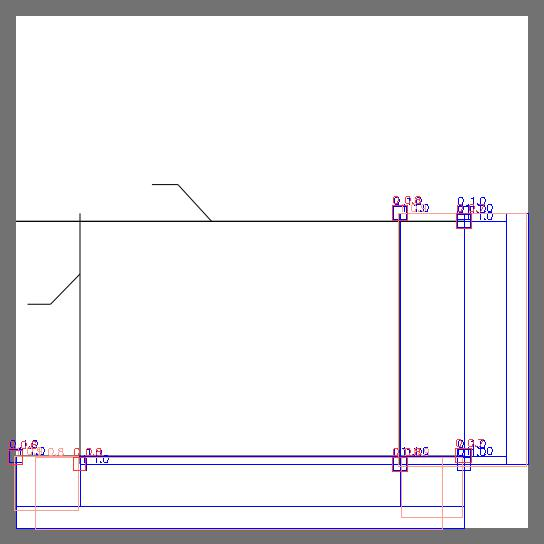

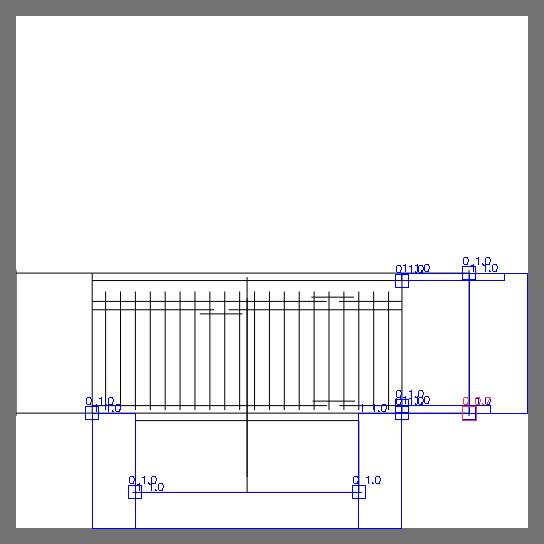

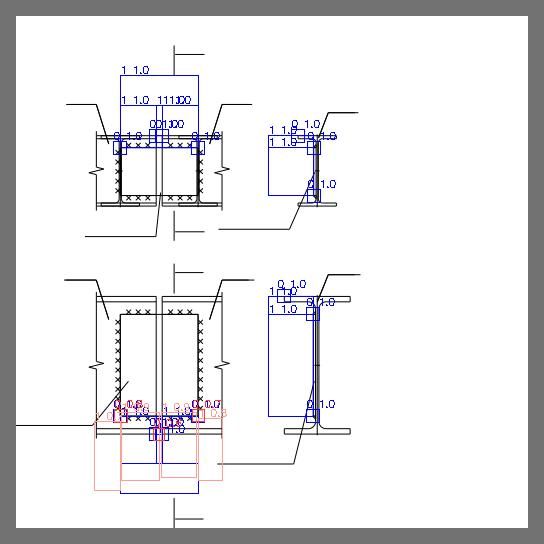

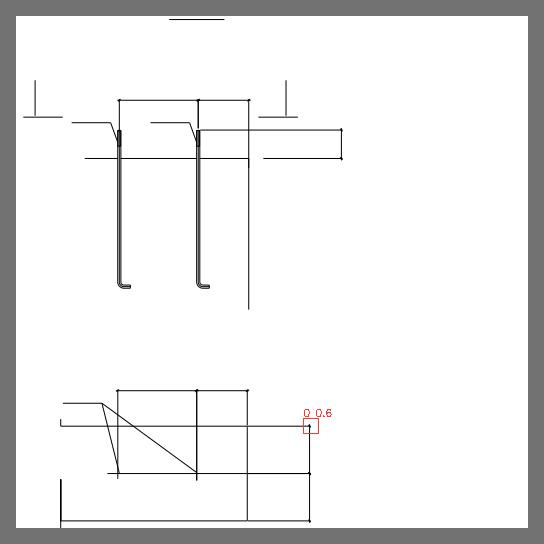

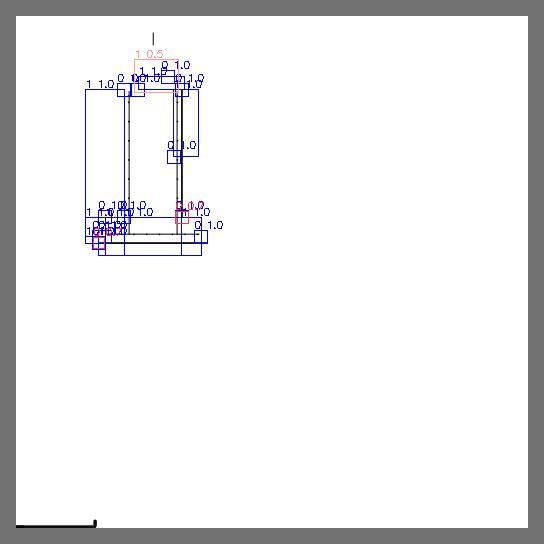

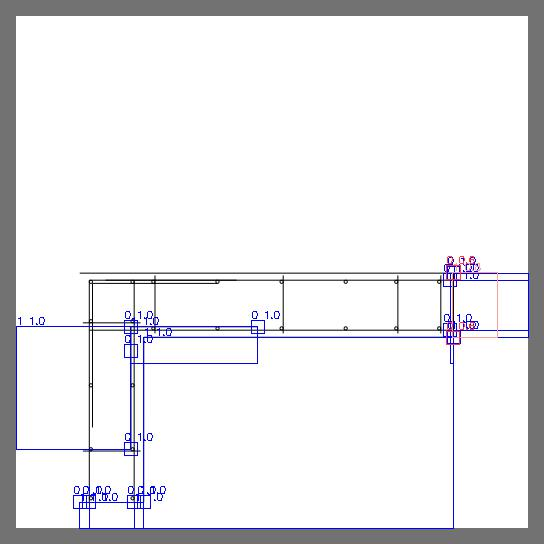

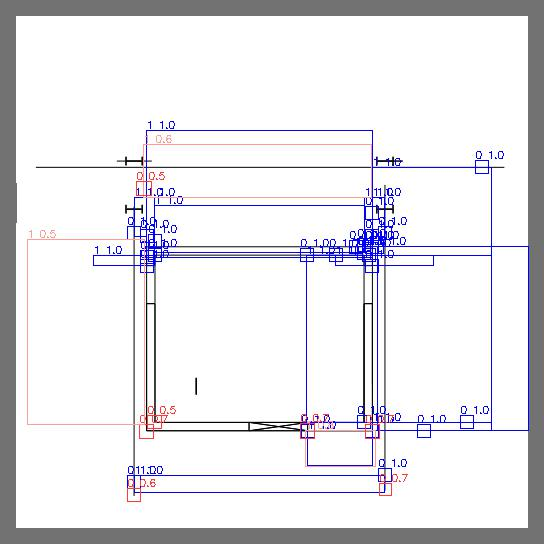

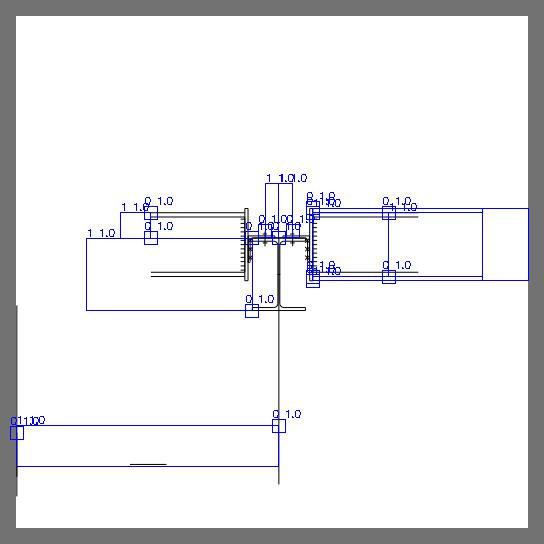

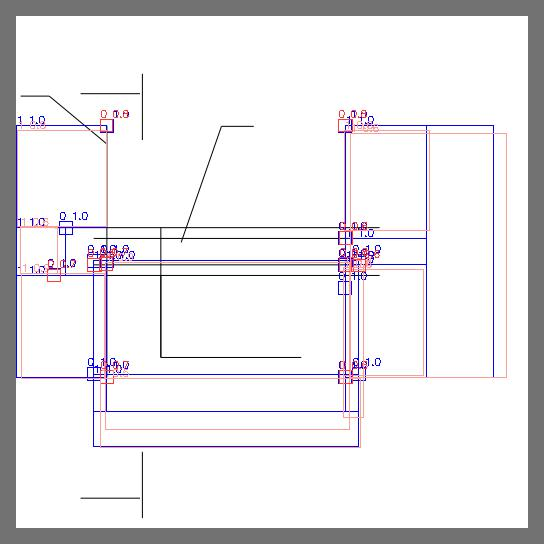

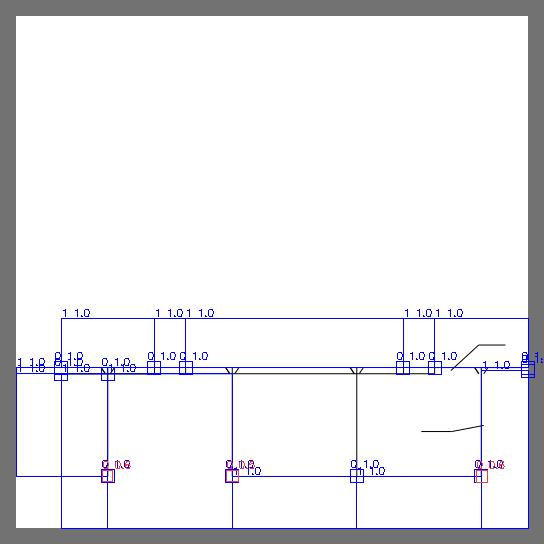

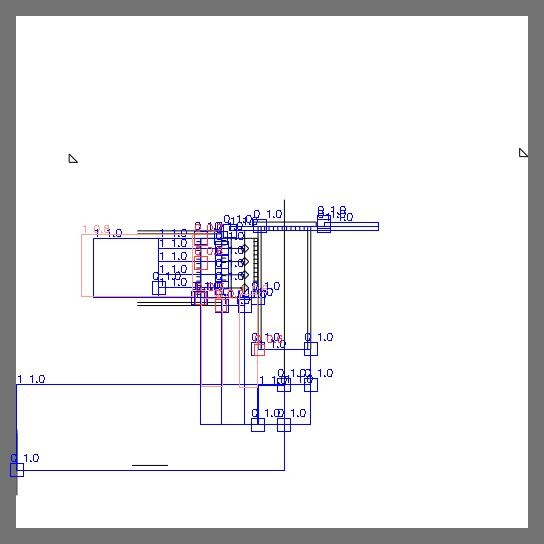

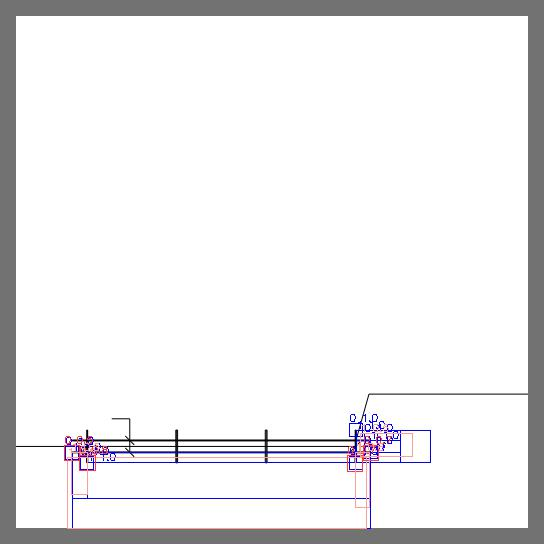

               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:  25%|██▌       | 1/4 [00:05<00:17,  5.84s/it]

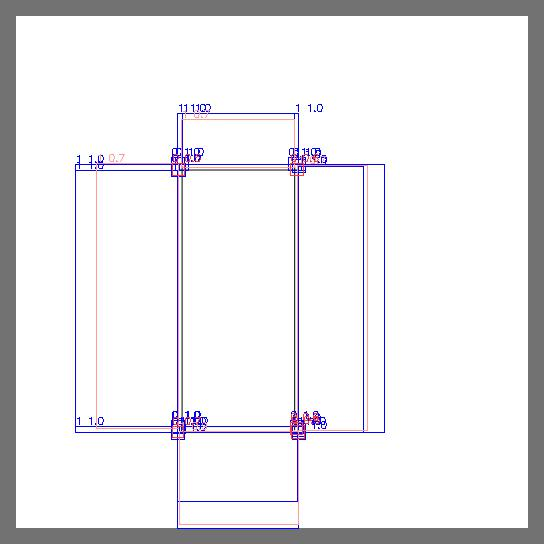

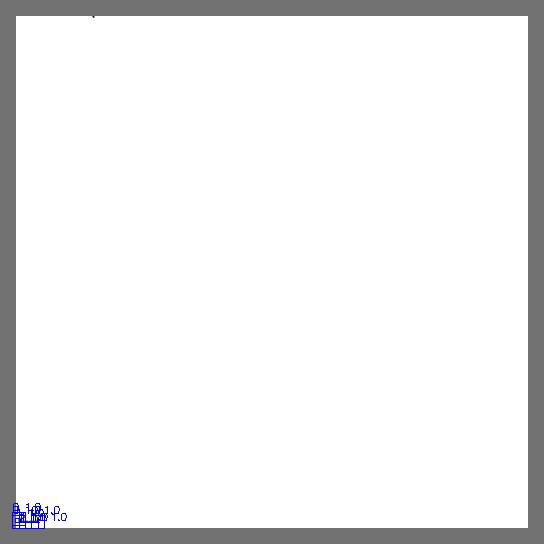

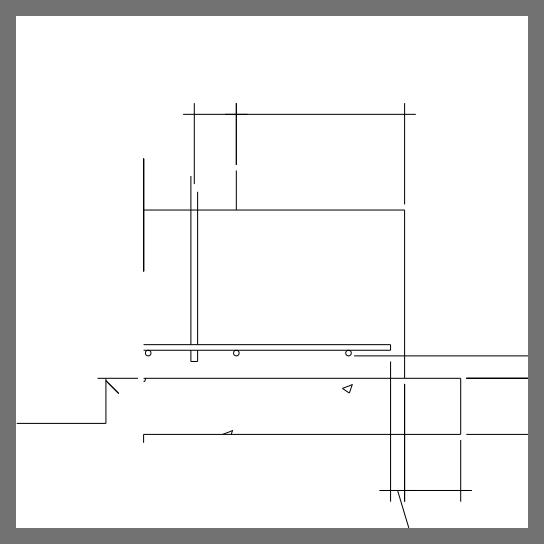

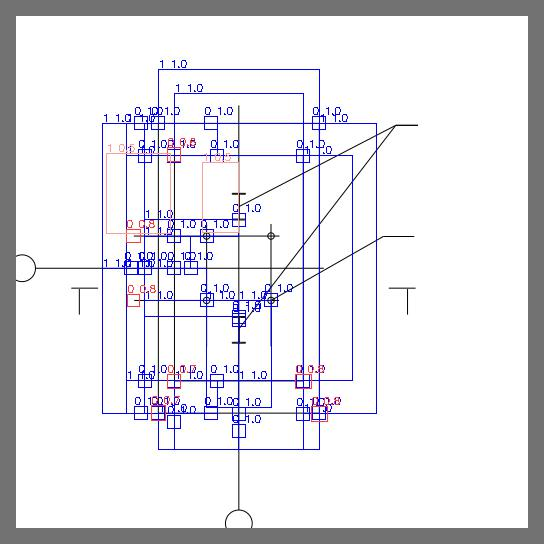

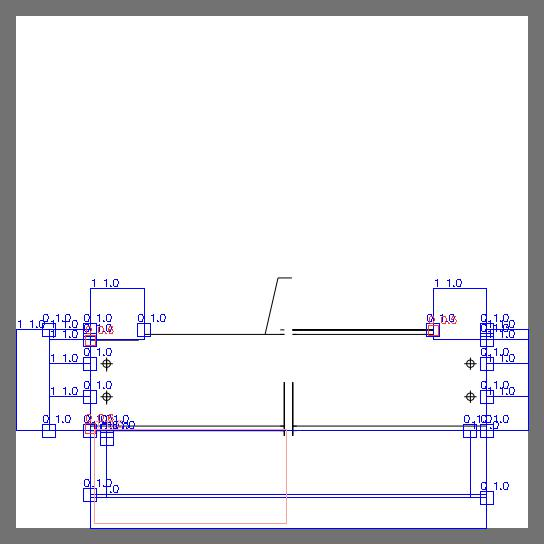

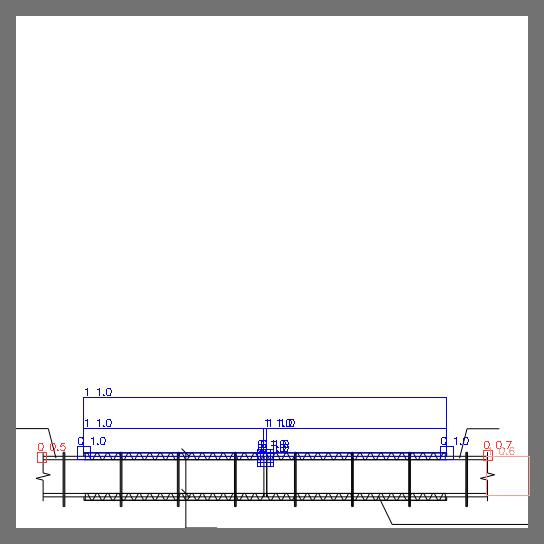

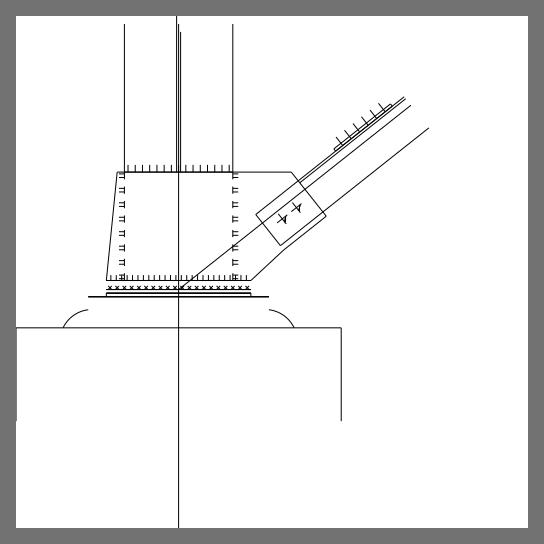

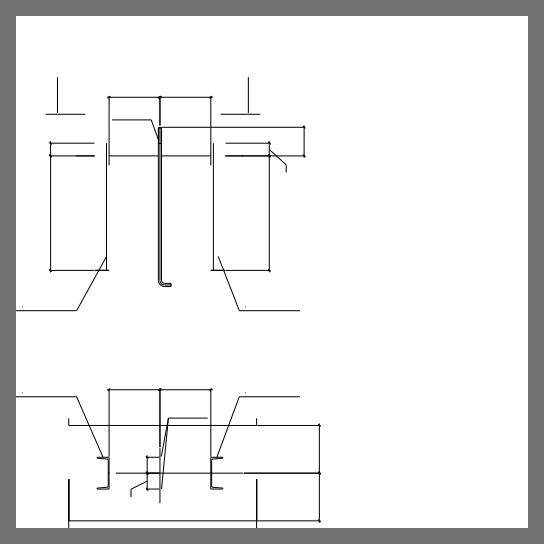

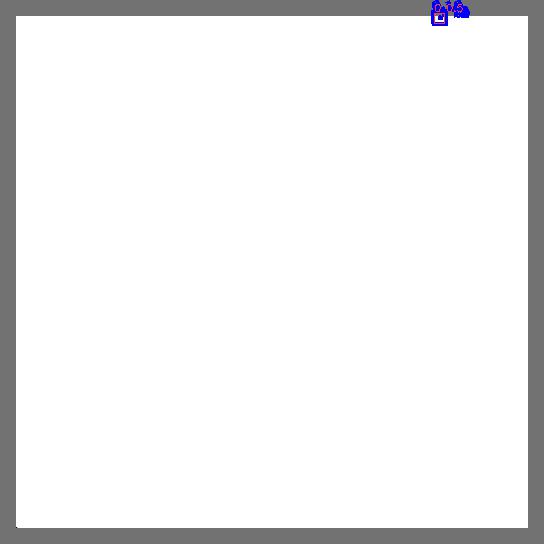

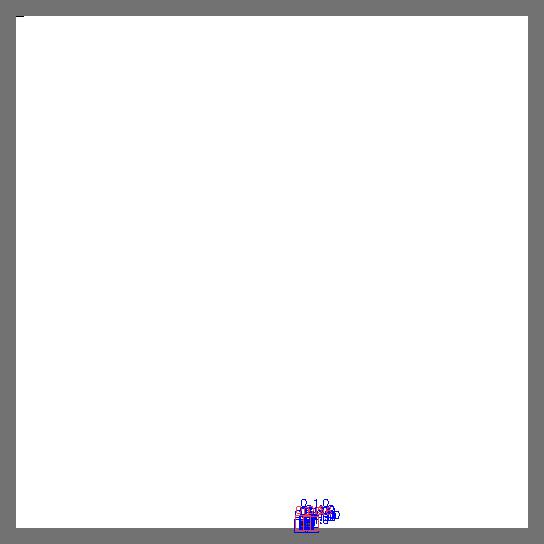

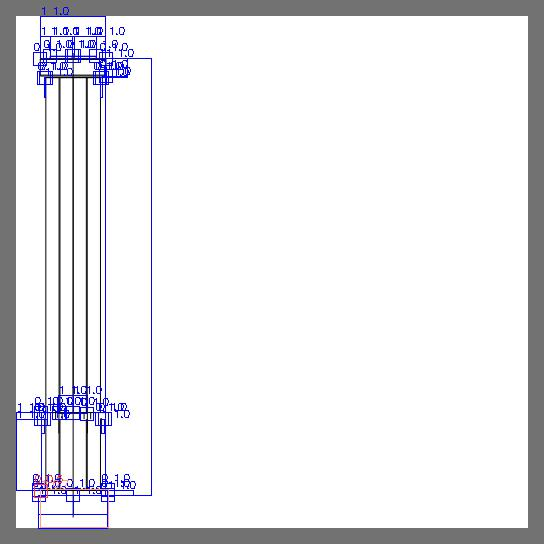

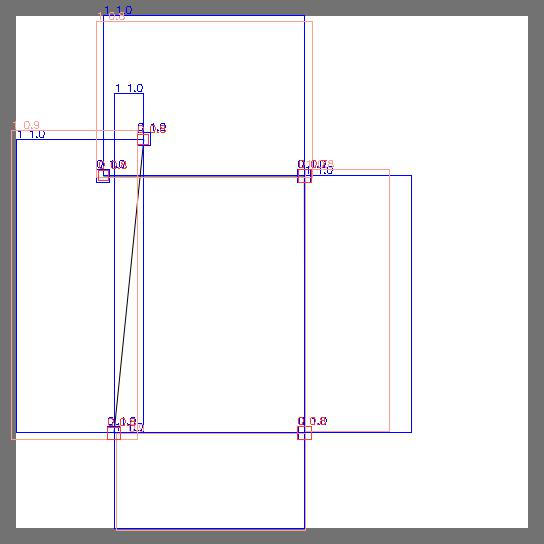

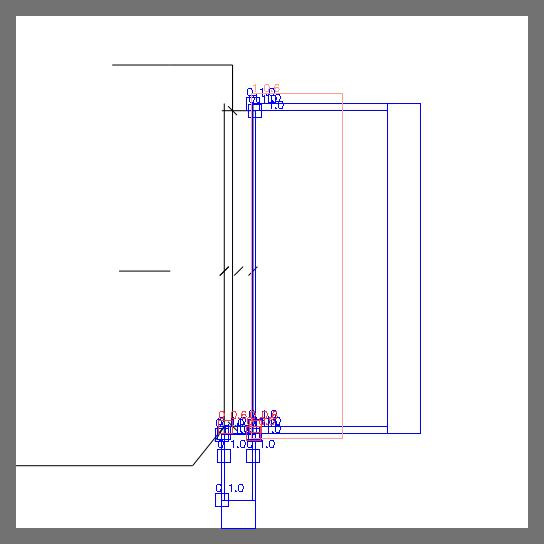

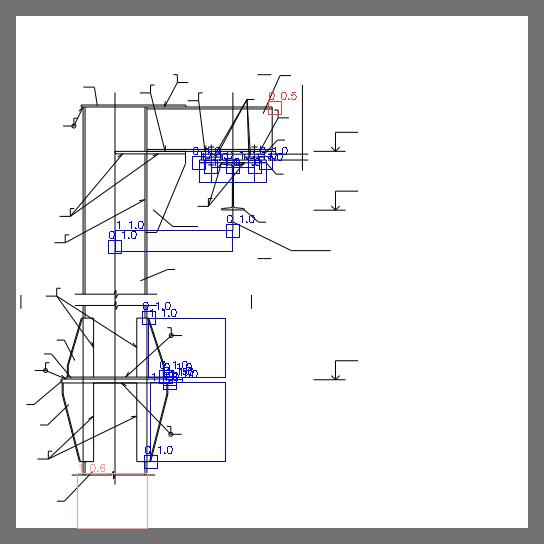

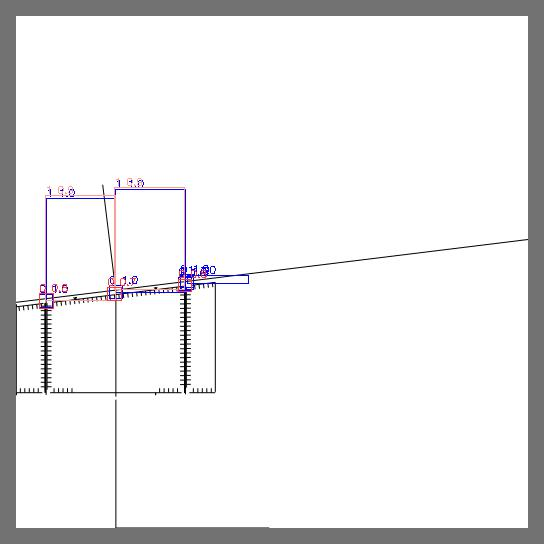

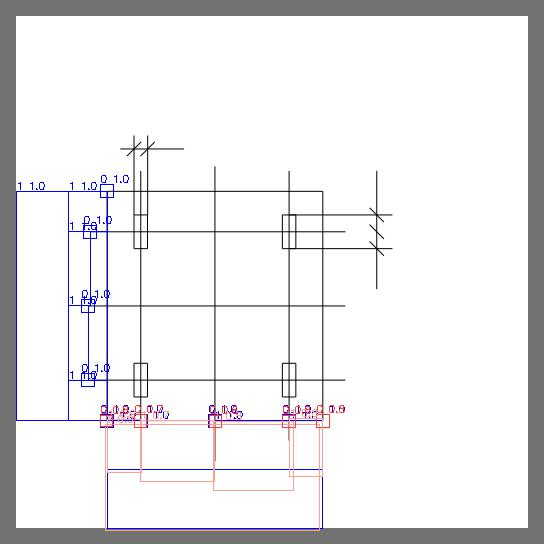

               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]

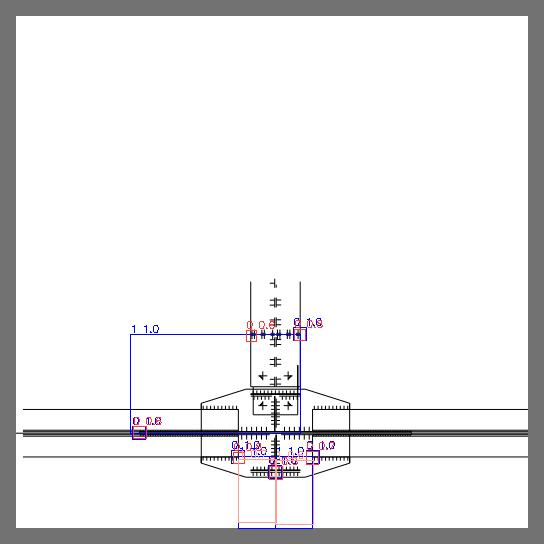

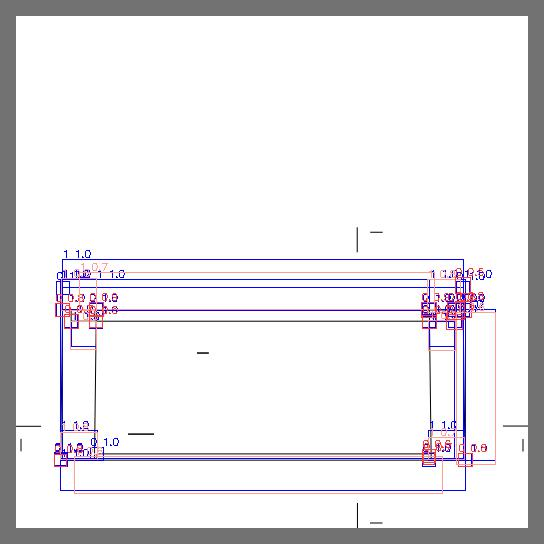

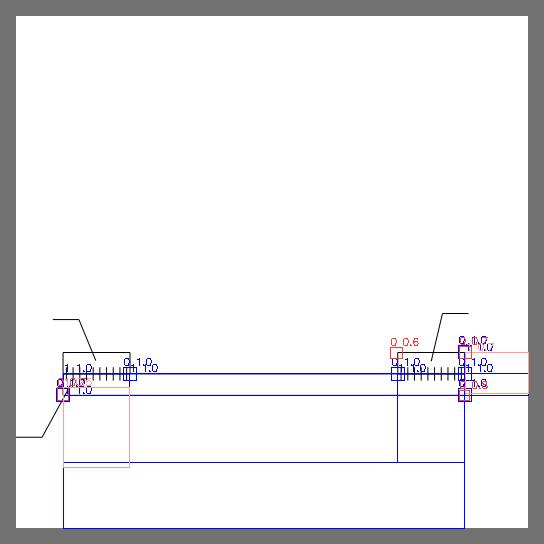

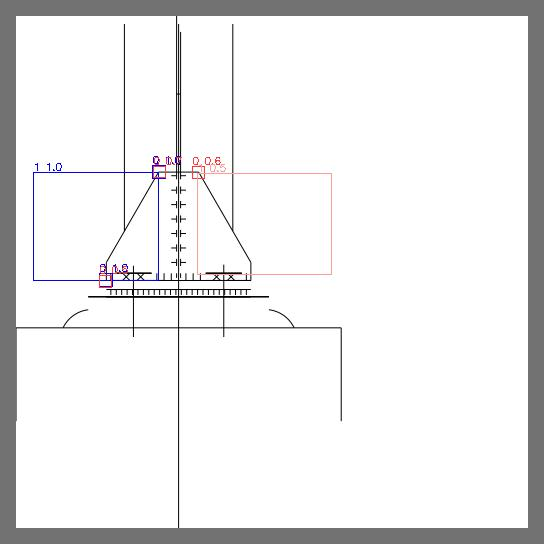

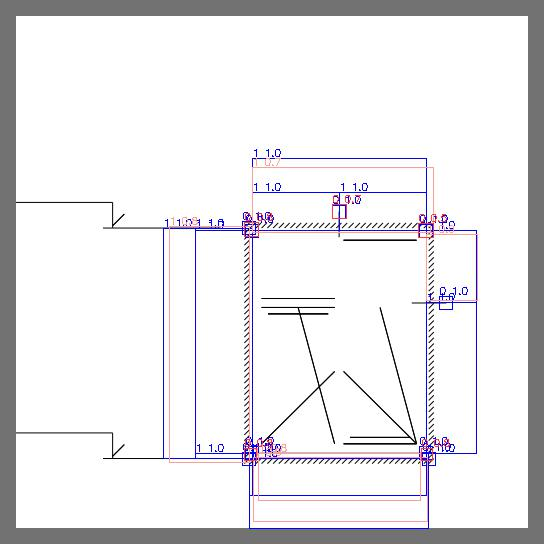

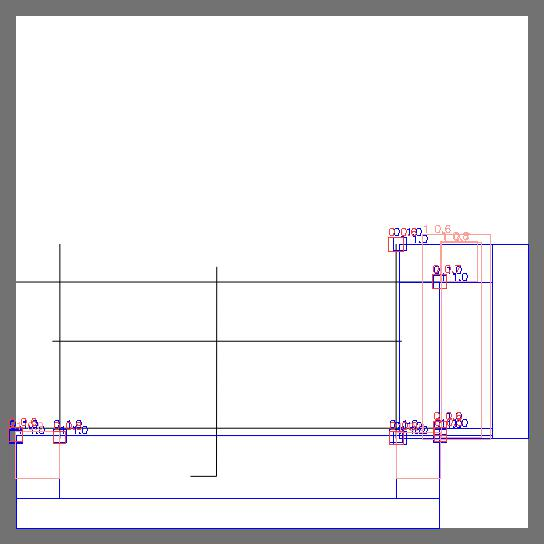

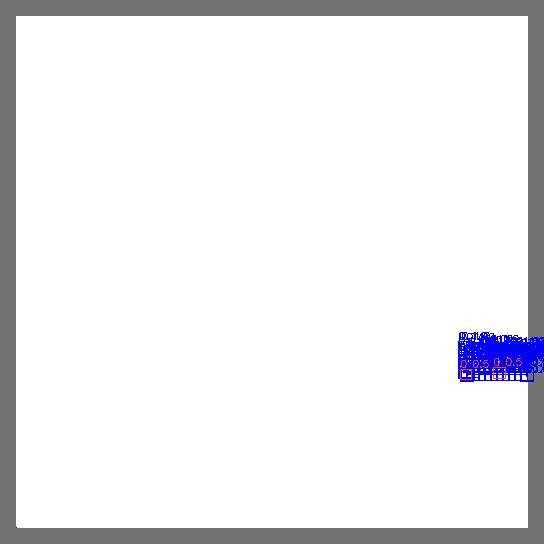

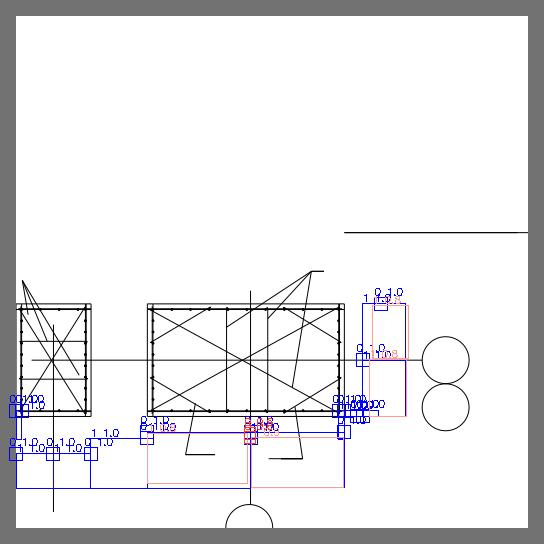

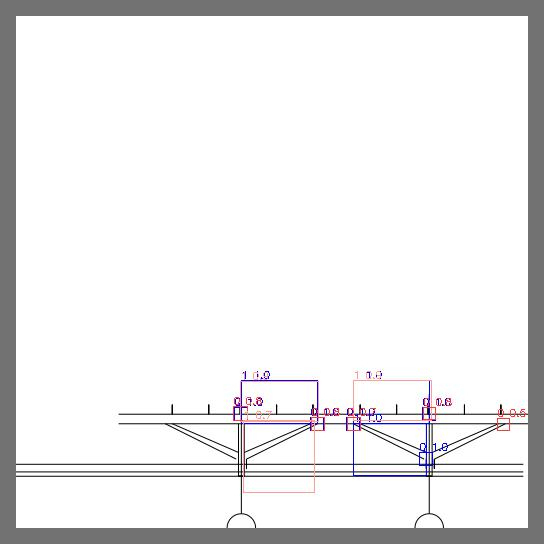

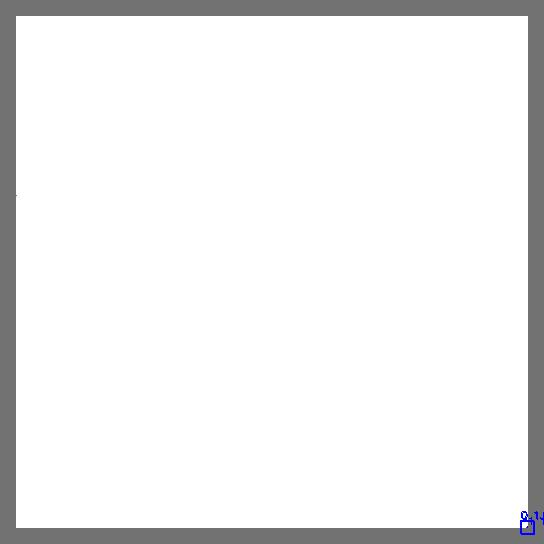

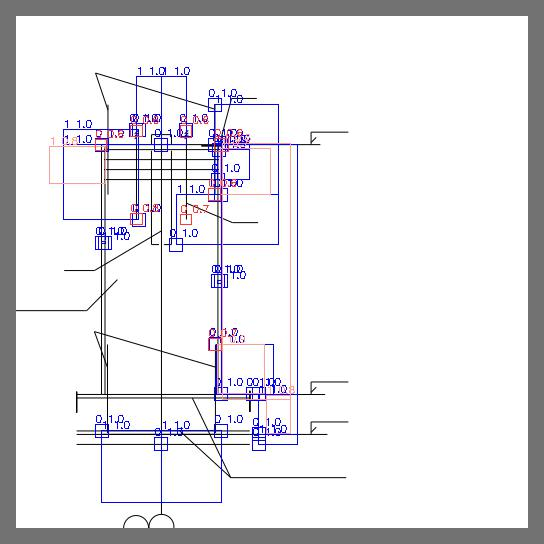

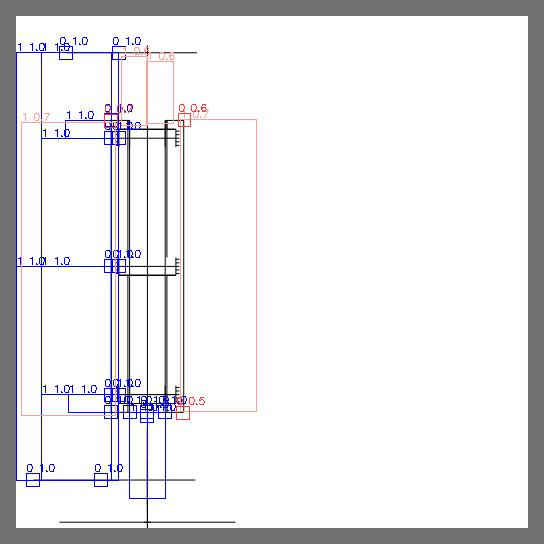

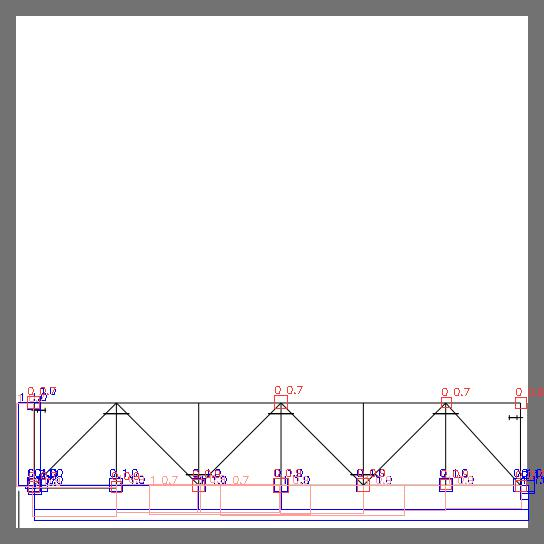

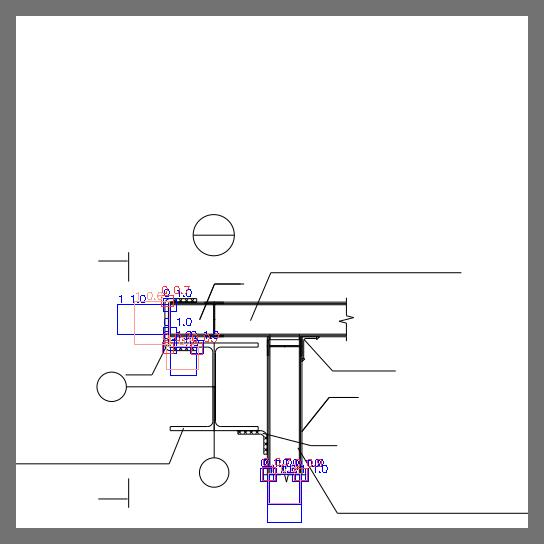

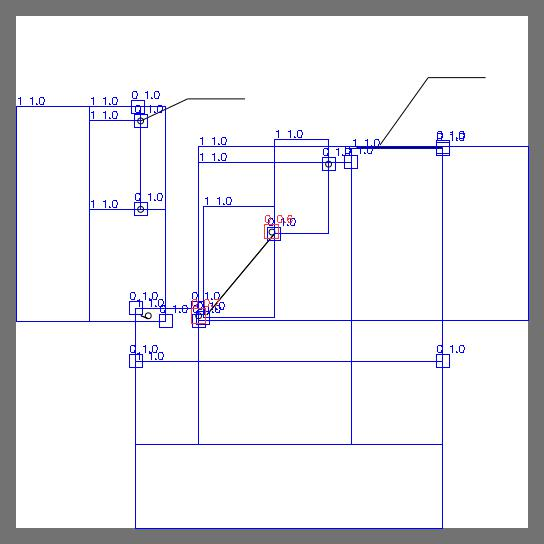

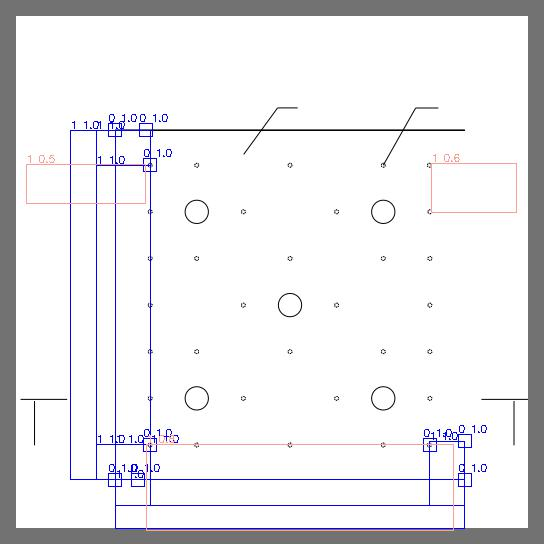

               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:  75%|███████▌  | 3/4 [00:16<00:05,  5.45s/it]

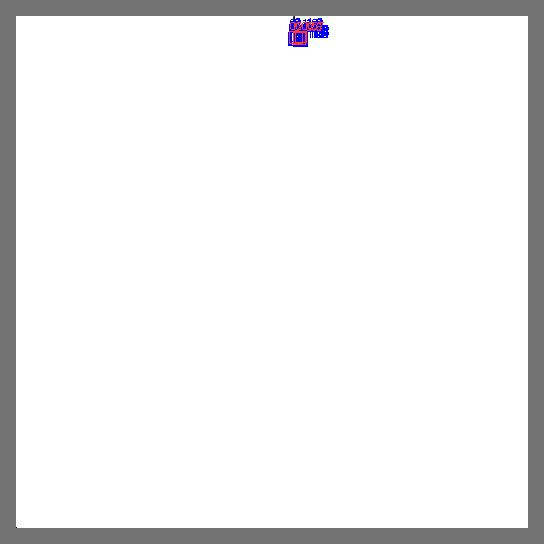

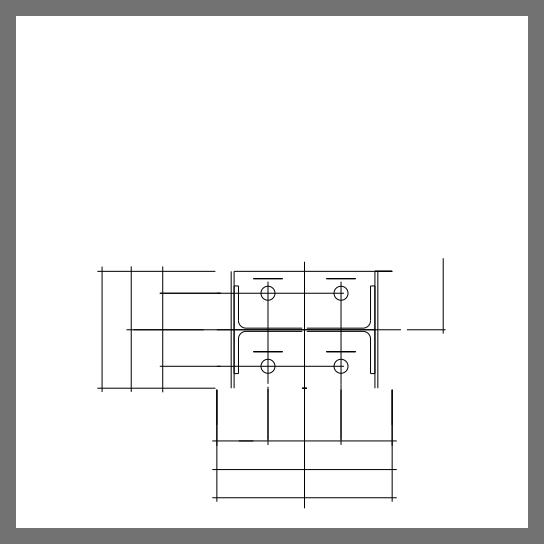

               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]


In [4]:
from draw_targets_and_predictions_jupyter import PlotEv
PlotEv()